In [1]:
import sys
sys.path[0] = ('/home/labs/waic/shahafw/DNN-Challenge')
from fastai.vision import *
import pre
import resample

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [23]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir, sub_mean=False):
    cgm, meals = pre.get_dfs(data_dir)
    if sub_mean:
        mean, std = pre.norm_stats['GlucoseValue']
        cgm['GlucoseValue'] = cgm['GlucoseValue'] - mean / std
        
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y
    
class AddNoise(Callback):
    
    def __init__(self, std):
        self.std = std
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train:
            return
        
        size = last_input.shape[0], last_input.shape[2]
        noise = torch.normal(0, self.std, size).to(last_input.device)
        last_input[:, -2] += noise
        return {'last_input': last_input}


In [3]:
train_data = get_data(train)
val_data = get_data(val)
train_data[1].head()

/home/labs/waic/shahafw/DNN-Challenge/pre.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


weight  alanine_g  alcohol_g  arginine_g  caffeine_mg  \
id Date                                                                         
46 2015-01-05 10:18:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 10:33:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 10:48:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 11:03:00     0.0        0.0        0.0         0.0          0.0   
   2015-01-05 11:18:00     0.0        0.0        0.0         0.0          0.0   

                        calcium_mg  carbohydrate_g  cholesterol_mg  \
id Date                                                              
46 2015-01-05 10:18:00         0.0             0.0             0.0   
   2015-01-05 10:33:00         0.0             0.0             0.0   
   2015-01-05 10:48:00         0.0             0.0             0.0   
   2015-01-05 11:03:00         0.0             0.0             0.0   
   2015-01-05 11:18:00         0.0             0.0             0.0   

                        energy_kcal  fructose_g  ...  \
id Date                                          ...   
46 2015-01-05 10:18:00          0.0         0.0  ...   
   2015-01-05 10:33:00          0.0         0.0  ...   
   2015-01-05 10:48:00          0.0         0.0  ...   
   2015-01-05 11:03:00          0.0         0.0  ...   
   2015-01-05 11:18:00          0.0         0.0  ...   

                        totalpolyunsaturatedfattyacids_g  \
id Date                                                    
46 2015-01-05 10:18:00                               0.0   
   2015-01-05 10:33:00                               0.0   
   2015-01-05 10:48:00                               0.0   
   2015-01-05 11:03:00                               0.0   
   2015-01-05 11:18:00                               0.0   

                        totalsaturatedfattyacids_g  totaltransfattyacids_g  \
id Date                                                                      
46 2015-01-05 10:18:00                         0.0                     0.0   
   2015-01-05 10:33:00                         0.0                     0.0   
   2015-01-05 10:48:00                         0.0                     0.0   
   2015-01-05 11:03:00                         0.0                     0.0   
   2015-01-05 11:18:00                         0.0                     0.0   

                        vitaminc_mg  vitamind_iu  vitamine_mg  water_g  \
id Date                                                                  
46 2015-01-05 10:18:00          0.0          0.0          0.0      0.0   
   2015-01-05 10:33:00          0.0          0.0          0.0      0.0   
   2015-01-05 10:48:00          0.0          0.0          0.0      0.0   
   2015-01-05 11:03:00          0.0          0.0          0.0      0.0   
   2015-01-05 11:18:00          0.0          0.0          0.0      0.0   

                        zinc_mg  GlucoseValue      time  
id Date                                                  
46 2015-01-05 10:18:00      0.0      6.647964  0.429167  
   2015-01-05 10:33:00      0.0      6.465828  0.439583  
   2015-01-05 10:48:00      0.0      6.101556  0.450000  
   2015-01-05 11:03:00      0.0      6.010488  0.460417  
   2015-01-05 11:18:00      0.0      6.192624  0.470833  

[5 rows x 38 columns]

In [4]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7fa18046d668>;

Valid: <__main__.ContData object at 0x7fa18046da58>;

Test: None

In [5]:
from metrics import Pearson


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.gru(output[None], hidden)
        return output[0], hidden

    def initHidden(self, bs, device):
        return torch.zeros(1, bs, self.hidden_size, device=device)


In [6]:
MAX_LENGTH = 49

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Linear(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights[:, None], encoder_outputs)

        output = torch.cat((embedded, attn_applied[:, 0]), 1)
        output = self.attn_combine(output)

        output = F.relu(output)
        output, hidden = self.gru(output[None], hidden)

        output = self.out(output[0])
        return output, hidden, attn_weights

    def initHidden(self, bs, device):
        return torch.zeros(1, bs, self.hidden_size, device=device)

In [7]:
class Seq2Seq(Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = EncoderRNN(input_size, hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size)
        
    def forward(self, input):
        device = input.device
        bs = input.shape[0]
        input = input.transpose(0, 1)
        
        encoder_hidden = self.encoder.initHidden(bs, device)
        encoder_outputs = input.new_zeros(bs, MAX_LENGTH, self.encoder.hidden_size)
        
        for ei in range(input.shape[0]):
            encoder_output, encoder_hidden = self.encoder(input[ei], encoder_hidden)
            encoder_outputs[:, ei] = encoder_output
            
        decoder_input = input.new_zeros(bs, 1)
        decoder_hidden = encoder_hidden
        
        out = []
        for di in range(8):
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            out.append(decoder_output)
            decoder_input = decoder_output.detach()
            
        out = torch.cat(out, dim=1)
        return out

In [8]:
model = Seq2Seq(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=metrics)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-01
Min loss divided by 10: 7.59E-08


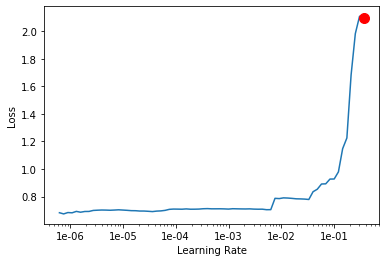

In [9]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [10]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.467034,0.455205,0.456504,0.589672,11:00
1,0.438910,0.428700,0.455828,0.618174,10:59
2,0.438002,0.419955,0.439907,0.624752,11:00
3,0.415198,0.418630,0.446167,0.629208,11:00
4,0.408633,0.412898,0.443213,0.634062,11:00
5,0.398597,0.409650,0.432097,0.637286,11:00
6,0.393649,0.412580,0.439982,0.633386,11:00
7,0.387743,0.415340,0.439767,0.631497,11:00
8,0.378304,0.415359,0.437265,0.633487,10:59
9,0.383180,0.416253,0.438513,0.632628,11:01


In [11]:
learner.save('gru1-h128')

In [12]:
train_data = get_data(train, sub_mean=True)
val_data = get_data(val, sub_mean=True)

/home/labs/waic/shahafw/DNN-Challenge/pre.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


In [13]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7fa133a9a2e8>;

Valid: <__main__.ContData object at 0x7fa133a9a978>;

Test: None

In [14]:
model = Seq2Seq(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=metrics)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 3.98E-03


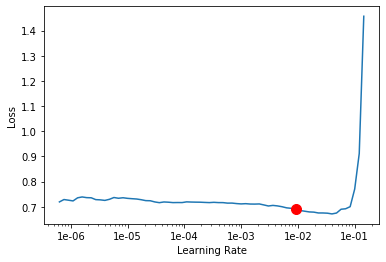

In [15]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [16]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.463613,0.448347,0.460471,0.599987,11:00
1,0.435627,0.424846,0.440055,0.622284,11:00
2,0.412784,0.419204,0.450172,0.629860,11:00
3,0.405501,0.413710,0.441343,0.635844,11:01
4,0.399700,0.417817,0.444857,0.634871,11:00
5,0.391910,0.415822,0.436573,0.629645,11:00
6,0.382016,0.422799,0.437793,0.630730,11:00
7,0.374567,0.427768,0.441394,0.626779,11:00
8,0.367669,0.433348,0.444706,0.624469,10:59
9,0.365605,0.435136,0.445306,0.623284,10:59


## with noise

In [28]:
model = Seq2Seq(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=metrics, callbacks=AddNoise(0.1))

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 4.79E-03


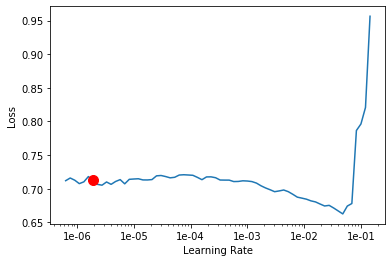

In [29]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(10, 1e-3)

## Seq2Lin

In [36]:
train_data = get_data(train)
val_data = get_data(val)
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7fa18027d4e0>;

Valid: <__main__.ContData object at 0x7fa180524b00>;

Test: None

In [42]:
class Seq2Lin(Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = EncoderRNN(input_size, hidden_size)
        self.self_attention = SelfAttention(MAX_LENGTH) if self_attention else None
        self.relu = nn.ReLU(inplace=True)
        self.decoder = nn.Linear(hidden_size, 8)

        
    def forward(self, input):
        device = input.device
        bs = input.shape[0]
        input = input.transpose(0, 1)
        
        encoder_hidden = self.encoder.initHidden(bs, device)
        encoder_outputs = input.new_zeros(bs, MAX_LENGTH, self.encoder.hidden_size)
        
        for ei in range(input.shape[0]):
            encoder_output, encoder_hidden = self.encoder(input[ei], encoder_hidden)
            encoder_outputs[:, ei] = encoder_output

        encoder_outputs = self.self_attention(encoder_outputs)
        out = encoder_outputs.permute(1, 2, 0)
        out = self.lin1(out)
        out = self.relu(out)
        out = self.lin2(encoder_outputs.view(bs, -1))
        return out

In [43]:
model = Seq2Lin(38, 128)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=metrics, callbacks=AddNoise(0.1))

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 6.31E-08


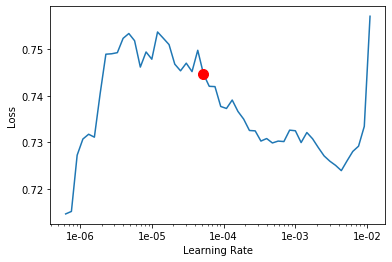

In [44]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [45]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.464642,0.457642,0.461495,0.588714,10:49
1,0.452136,0.441908,0.447939,0.611890,10:46
2,0.437998,0.432599,0.458448,0.613500,10:45
3,0.426530,0.424275,0.443634,0.620695,10:48
4,0.419213,0.421201,0.446459,0.623960,10:47
5,0.410678,0.418990,0.440206,0.627635,10:48
6,0.400115,0.418854,0.440297,0.629372,10:47
7,0.401766,0.419536,0.444947,0.626894,10:45
8,0.391705,0.420235,0.442031,0.627846,10:47
9,0.388078,0.420398,0.443884,0.627196,10:44
